# Fish Image Classification with ANN
In this project, we will use a large-scale fish image dataset to build an Artificial Neural Network (ANN) for fish classification. The steps include data preprocessing, model training, evaluation, and visualization of the results.

---

## 1. Importing Libraries and Downloading Dataset
We start by importing the necessary libraries and downloading the dataset from Kaggle. The dataset contains multiple classes of fish images that we will use to train our model.


In [1]:
# Kütüphaneleri import etme
import os
import shutil
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

---

## 2. Data Preprocessing
Here, we load the images, extract their file paths, and labels. We then merge them into a single dataframe for easier manipulation. We also shuffle the dataset to ensure randomness before splitting it into training, validation, and test sets.

---


In [2]:
# Kaggle veri kümesini yükleme
crowww_a_large_scale_fish_dataset_path = kagglehub.dataset_download('crowww/a-large-scale-fish-dataset')

print('Data source import complete.')

# Veri setini ayarlama
direc = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')
filepaths = list(direc.glob(r'**/*.png'))
Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='FilePaths').astype(str)
Labels = pd.Series(Labels, name='Labels').astype(str)

img_df = pd.merge(filepaths, Labels, right_index=True, left_index=True)
img_df = img_df[img_df['Labels'].apply(lambda x: x[-2:] != 'GT')]  # GT etiketlerini kaldır


Data source import complete.


---

## 3. Data Visualization
Before proceeding with model training, let's visualize some sample images from the dataset along with their corresponding labels to understand the diversity of data.

---


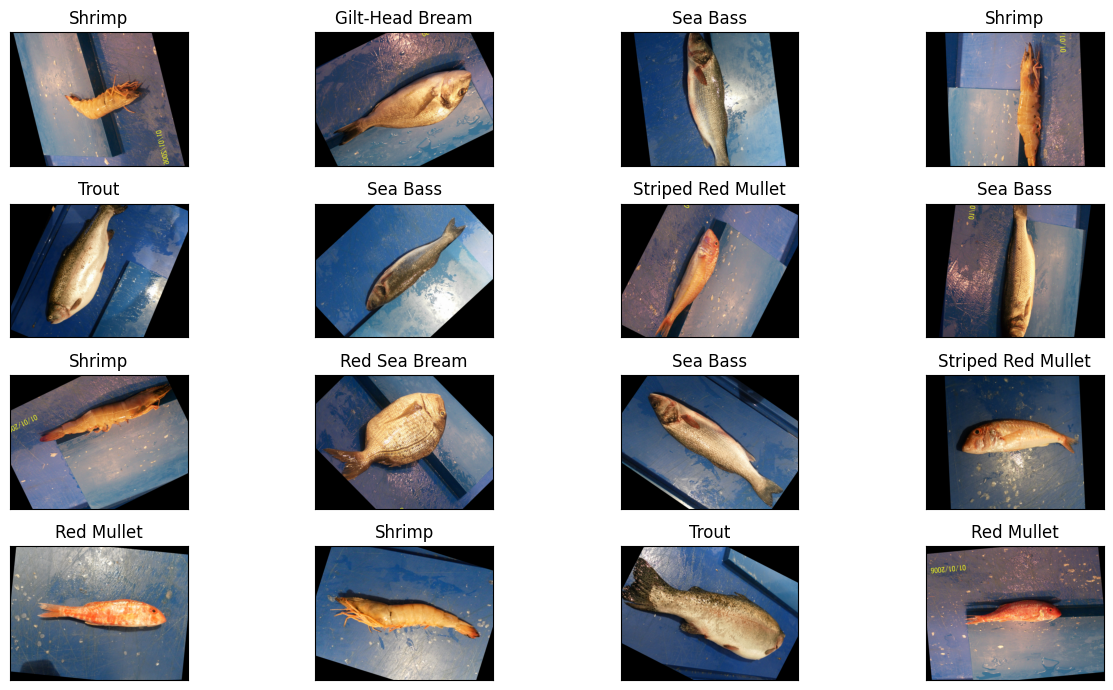

 Count of Rows : 9000 
 Count of Columns : 2 
Labels
Shrimp                1000
Gilt-Head Bream       1000
Sea Bass              1000
Trout                 1000
Striped Red Mullet    1000
Red Sea Bream         1000
Red Mullet            1000
Hourse Mackerel       1000
Black Sea Sprat       1000
Name: count, dtype: int64


In [3]:
# Veri setini karıştırma
img_df = img_df.sample(frac=1).reset_index(drop=True)
img_df.head()

# Görüntüleri gösterme
f, a = plt.subplots(nrows=4, ncols=4, figsize=(13, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(img_df.FilePaths[i]))
    ax.set_title(img_df.Labels[i])

plt.tight_layout()
plt.show()

print(f" Count of Rows : {img_df.shape[0]} \n Count of Columns : {img_df.shape[1]} ")
print(img_df['Labels'].value_counts(ascending=True))

---

## 4. Splitting the Dataset
We split the dataset into three parts: training (75%), validation (10%), and testing (15%) to train and evaluate our model effectively.

---


In [5]:
# Veri setini bölme
train_ratio = 0.75
validation_ratio = 0.10
test_ratio = 0.15

x_train, x_test = train_test_split(img_df, test_size=1 - train_ratio)
x_val, x_test = train_test_split(x_test, test_size=test_ratio/(test_ratio + validation_ratio))

print(f'Shape of Training Data : ', x_train.shape)
print(f'Shape of Testing Data : ', x_test.shape)
print(f'Shape of Validation Data : ', x_val.shape)

Shape of Training Data :  (6750, 2)
Shape of Testing Data :  (1350, 2)
Shape of Validation Data :  (900, 2)


---

## 5. Image Augmentation
To improve the performance of the model, we perform data augmentation. This step helps in creating variations of images for robust model learning.

---


In [6]:
# Görüntü veri artırma
img_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)
img_size = (224, 224)

x_train = img_datagen.flow_from_dataframe(dataframe=x_train, x_col='FilePaths', y_col='Labels', 
                                           target_size=img_size, color_mode='rgb', class_mode='categorical', 
                                           batch_size=32, seed=42)
x_test = img_datagen.flow_from_dataframe(dataframe=x_test, x_col='FilePaths', y_col='Labels', 
                                          target_size=img_size, color_mode='rgb', class_mode='categorical', 
                                          batch_size=32, seed=42)
x_val = img_datagen.flow_from_dataframe(dataframe=x_val, x_col='FilePaths', y_col='Labels', 
                                         target_size=img_size, color_mode='rgb', class_mode='categorical', 
                                         batch_size=32, seed=42)


Found 6750 validated image filenames belonging to 9 classes.
Found 1350 validated image filenames belonging to 9 classes.
Found 900 validated image filenames belonging to 9 classes.


---

## 6. Building the ANN Model
We construct an Artificial Neural Network (ANN) model with multiple dense layers and dropout layers to prevent overfitting. The model will take in 224x224 RGB images and output a prediction among the 9 possible fish classes.

---


In [8]:
# Modelin oluşturulması
fc_model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation="softmax")
])

fc_model.compile(optimizer="adam",
                 loss="categorical_crossentropy",
                 metrics=["accuracy"])

---

## 7. Model Training
We train the model using the training data and validate it on the validation set for 10 epochs. Early stopping is applied to avoid overfitting by monitoring accuracy.

---
---

## 8. Saving the Model
After training the model, we save it for future use, so we can load it and perform predictions without retraining.

---


In [9]:
# Modeli eğitme
Callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)
mo_fit = fc_model.fit(x_train,
                      validation_data=x_val,
                      epochs=10,
                      callbacks=[Callback])

# Modelin kaydedilmesi
fc_model.save('fish_classification_model.h5')

# Test verisi üzerinde değerlendirme yapma
test_accuracy = fc_model.evaluate(x_test)[1] * 100
print('Test accuracy is : ', test_accuracy, '%')


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


211/211 ━━━━━━━━━━━━━━━━━━━━ 195s 890ms/step - accuracy: 0.3096 - loss: 1.8433 - val_accuracy: 0.6678 - val_loss: 0.9656
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 129s 598ms/step - accuracy: 0.6468 - loss: 1.0126 - val_accuracy: 0.7267 - val_loss: 0.7302
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 129s 595ms/step - accuracy: 0.7566 - loss: 0.7031 - val_accuracy: 0.8200 - val_loss: 0.5206
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 131s 608ms/step - accuracy: 0.8361 - loss: 0.4879 - val_accuracy: 0.8867 - val_loss: 0.3351
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 130s 601ms/step - accuracy: 0.8730 - loss: 0.3595 - val_accuracy: 0.8778 - val_loss: 0.3562
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 129s 595ms/step - accuracy: 0.9025 - loss: 0.2839 - val_accuracy: 0.9078 - val_loss: 0.2691
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 129s 595ms/step - accuracy: 0.9207 - loss: 0.2346 - val_accuracy: 0.9411 - val_loss: 0.1943
Epoch 8/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 127s 590ms/step - accuracy: 0.9460 - loss: 0.16

---

## 9. Model Evaluation
We evaluate the trained model on the test set to determine its accuracy. We also generate a confusion matrix and classification report to understand the performance on each class.

---


43/43 ━━━━━━━━━━━━━━━━━━━━ 18s 412ms/step


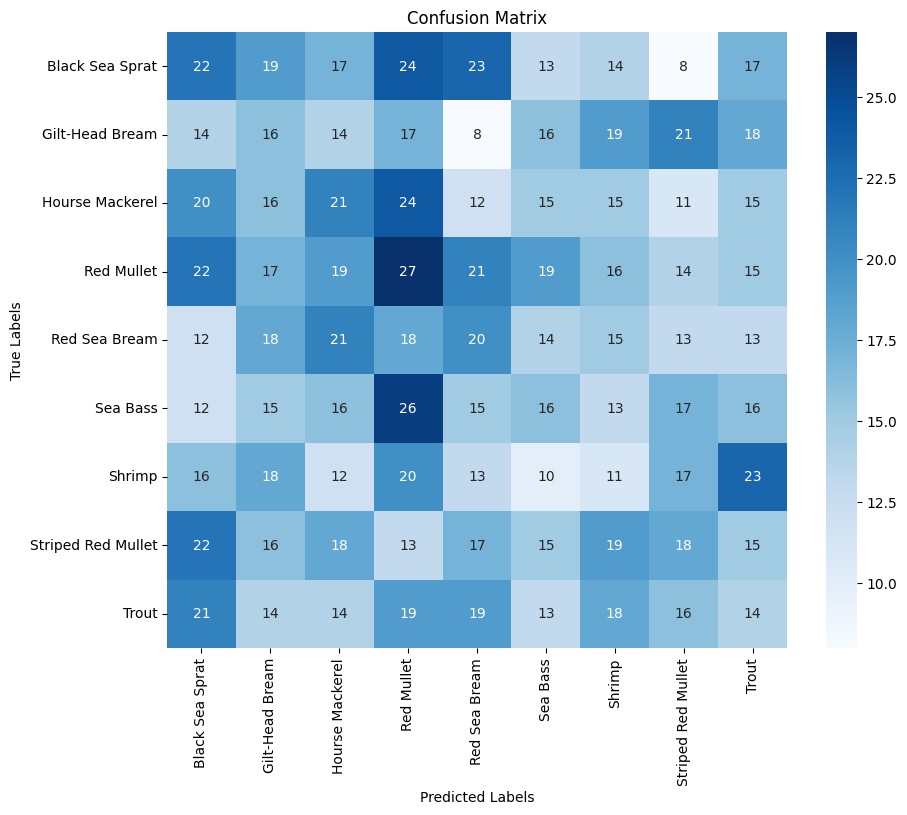

In [10]:
# Karışıklık matrisini hesaplama
y_true = x_test.classes  # Gerçek etiketler
y_pred = np.argmax(fc_model.predict(x_test), axis=1)  # Tahmin edilen etiketler

conf_matrix = confusion_matrix(y_true, y_pred)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=x_test.class_indices.keys(),
            yticklabels=x_test.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

---

## 10. Visualization of Training Progress
Lastly, we visualize the training and validation accuracy, as well as the loss, to understand how well the model has learned over time.

---


                    precision    recall  f1-score   support

   Black Sea Sprat       0.14      0.14      0.14       157
   Gilt-Head Bream       0.11      0.11      0.11       143
   Hourse Mackerel       0.14      0.14      0.14       149
        Red Mullet       0.14      0.16      0.15       170
     Red Sea Bream       0.14      0.14      0.14       144
          Sea Bass       0.12      0.11      0.12       146
            Shrimp       0.08      0.08      0.08       140
Striped Red Mullet       0.13      0.12      0.12       153
             Trout       0.10      0.09      0.10       148

          accuracy                           0.12      1350
         macro avg       0.12      0.12      0.12      1350
      weighted avg       0.12      0.12      0.12      1350



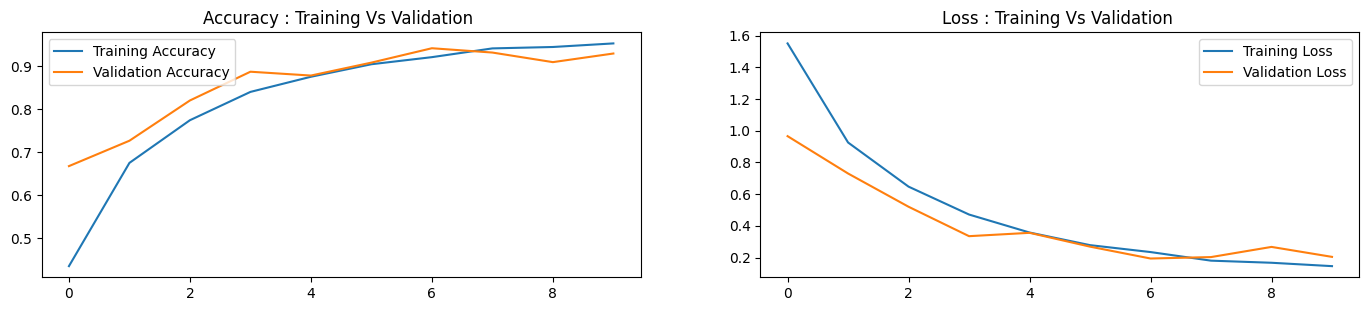

In [12]:
# Sınıflandırma raporunu yazdırma
print(classification_report(y_true, y_pred, target_names=x_test.class_indices.keys()))

# Eğitim sonuçlarını görselleştirme
accuracy = mo_fit.history['accuracy']
loss = mo_fit.history['loss']
validation_loss = mo_fit.history['val_loss']
validation_accuracy = mo_fit.history['val_accuracy']

plt.figure(figsize=(17, 7))
plt.subplot(2, 2, 1)
plt.plot(range(10), accuracy, label='Training Accuracy')
plt.plot(range(10), validation_accuracy, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy : Training Vs Validation ')

plt.subplot(2, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), validation_loss, label='Validation Loss')
plt.title('Loss : Training Vs Validation ')
plt.legend(loc='upper right')
plt.show()